# Part 2: Thermal Wind
Andrew Delman, updated 2023-01-07.

## Objectives

To use ECCO state estimate output to explore thermal wind and its use in understanding the ocean circulation.

By the end of the tutorial, you will be able to:
* Plot transects along lines of latitude in the ECCO native grid
* Rotate fields in model axes to true zonal/meridional orientation
* Relate the density structure to the direction of oceanic flow (thermal wind balance)
* Estimate oceanic velocity using thermal wind and assumption of a level of no motion

## Thermal wind

In the previous tutorial we established that geostrophic balance explains most of the oceanic circulation--at least at the spatial and temporal scales of ECCOv4r4 output. Now we consider thermal wind, a property of geostrophic flow that has been very useful to atmospheric and ocean scientists alike. Thermal wind balance is derived directly from geostrophic balance (in horizontal directions)

$$
v_g = \frac{1}{f\rho}\frac{\partial{p}}{\partial{x}}
$$
$$
u_g = -\frac{1}{f\rho}\frac{\partial{p}}{\partial{y}}
$$

and hydrostatic balance (in the vertical direction)

$$
\frac{\partial{p}}{\partial{z}} = -{\rho}g
$$

Therefore by differentiating geostrophic balance along the $z$ axis and assuming hydrostatic conditions, we get thermal wind balance:

$$
\frac{\partial{v_g}}{\partial{z}} = -\frac{g}{f\rho}\frac{\partial{\rho}}{\partial{x}}
$$
$$
\frac{\partial{u_g}}{\partial{z}} = \frac{g}{f\rho}\frac{\partial{\rho}}{\partial{y}}
$$

The *thermal wind* name originates from the application of these equations to atmospheric dynamics, where the velocities are the wind and density is mostly a function of temperature. But the balance is just as important to oceanic dynamics. In both the atmosphere and ocean, thermal wind enabled early measurements of temperature (and salinity in the ocean) to be used to construct velocity fields, where velocities are often difficult to measure directly. And even in present times when velocities can be measured directly, the thermal wind relation connects changes in heat and salt content to changes in the ocean circulation.

## Thermal wind along a line of latitude

### Plotting density

Let's use the density and velocity output datasets from ECCOv4r4 for January 2000, as used in the previous tutorial. This time, we'll focus on ```tile=10```, which is rotated counterclockwise so that the $j$ index increases with increasing longitude (not latitude), and the $i$ index increases with *decreasing* latitude. Tiles 7-12 (the 8th through 13th tiles, remember Python indexing starts at 0) are rotated in this way, as illustrated in the following tile plot

![llc90 tile layout](../figures/llc90_0.png)

Now we are going to load the density dataset and plot density on longitude-depth axes following the line in the grid nearest to $26^{o}$ N, i.e., ```i = 73```.

In [1]:
# first import needed packages
import numpy as np
import xarray as xr
import xmitgcm
import xgcm
import glob
from os.path import expanduser,join
import sys
user_home_dir = expanduser('~')
sys.path.append(user_home_dir + '/ECCOv4-py')   # only needed if ecco_v4_py files are stored under this directory
import matplotlib.pyplot as plt
import ecco_v4_py as ecco

In [2]:
# now open density and grid parameter files

# ShortNames
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
denspress_monthly_shortname = "ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4"
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"

# density file
download_root_dir = join(user_home_dir,'Downloads/ECCO_V4r4_PODAAC')
download_dir = join(download_root_dir,denspress_monthly_shortname)
curr_denspress_file = list(glob.glob(download_dir + '/*2000-01*.nc'))
ds_dens = xr.open_dataset(curr_denspress_file[0])

# load grid parameters file
grid_params_file = "GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc"
grid_params_file_path = join(download_root_dir,grid_params_shortname,grid_params_file)
ds_grid = xr.open_dataset(grid_params_file_path)

# find index closest to target latitude
lat_target = 26.
target_i = np.argmin(np.abs(ds_grid.YC[10,70,:].values - lat_target))
# the choice of j = 70 above is random, any j index from 0 to 89 will yield the same target_i
target_i

73

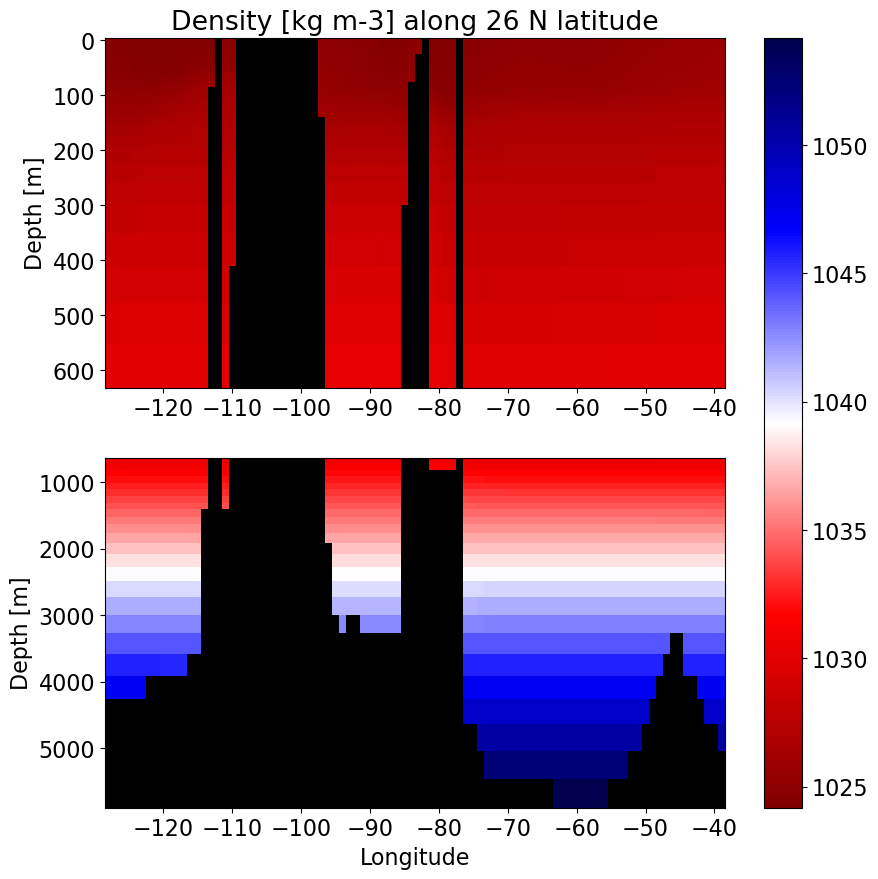

In [3]:
# plot density data along target latitude

# retrieve density field
densanom = ds_dens.RHOAnoma
rhoConst = 1029.
dens = rhoConst + densanom

# load land mask (a boolean array) from grid parameters
land_mask = ~ds_grid.maskC

# function to plot mask (same as used in geostrophic balance tutorial)
from matplotlib.colors import ListedColormap
def plot_mask(*args,ax,color_rgb):
    "Plot mask, given (optional) X and Y, 2-D mask, axes ax, and color_rgb, a 3-element NumPy array"    
    if len(args) == 1:
        mask = args[0]
    else:
        X = args[0]
        Y = args[1]
        mask = args[2]
    # set alpha values to 1 where mask is plotted, 0 otherwise
    if str(type(mask))[0:5] == 'xarray':
        mask = mask.values
    colormap = ListedColormap(np.concatenate((np.tile(color_rgb,(2,1)),np.array([[0],[1]])),axis=-1))
    # plot land mask
    if len(args) == 1:
        ax.pcolormesh(mask,cmap=colormap,vmin=0.,vmax=1.,zorder=50)
    else:
        ax.pcolormesh(X,Y,mask,cmap=colormap,vmin=0.,vmax=1.,zorder=50)
    if np.diff(ax.get_ylim()) < 0:
        ax.set_ylim(ax.get_ylim()[::-1])     # set direction of y-axis so that values increase upward

# plot density along latitude line
tile_plot = 10
i_plot = target_i
isel_dict = dict({'tile':tile_plot,'i':i_plot})
isel_dict_ig = dict({'tile':tile_plot,'i_g':i_plot})

plt.rcParams["font.size"] = 16        # set default font size for plots in this tutorial

# function to create 2 subplots
def depth_two_subplots(horiz_coords,depth_coords,data,k_split,cmap,mask=None,fig=None,axs=None):
    """
    Make 2 subplots with depth on y-axis, for shallow and deeper depths, given parameters:
    horiz_coords: horizontal coordinate, xarray DataArray
    depth_coords: depth_coordinate, xarray DataArray
    data: 2-D xarray DataArray
    k_split: k coordinate to split the plot at, integer
    cmap: string specifying colormap to use
    mask: 2-D boolean (land) mask, optional
    fig: figure object, optional, default is new figure is created
    axs: axes with two subplots oriented vertically, default is they are created
    """
    
    if (fig is None) and (axs is None):
        fig,axs = plt.subplots(2,1,figsize=(10,10))    # subplots for different depths
    elif (fig is None) or (axs is None):
        print("Warning: Only one of fig or axs has been supplied, not both")
    curr_ax = axs[0]
    curr_plot_0 = curr_ax.pcolormesh(horiz_coords,depth_coords[:k_split],\
                                      data.isel(k=np.arange(k_split)),cmap=cmap)                                      
    if mask is not None:
        curr_land_mask = mask.isel(k=np.arange(k_split))
        plot_mask(horiz_coords,depth_coords[:k_split],curr_land_mask,ax=curr_ax,color_rgb=np.zeros(3,))
    curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
    curr_ax.set_ylabel('Depth [m]')    
    clim_0 = curr_plot_0.get_clim()
    
    curr_ax = axs[1]
    curr_plot_1 = curr_ax.pcolormesh(horiz_coords,depth_coords[k_split:],\
                                      data.isel(k=np.arange(25,len(depth_coords))),cmap=cmap)                                      
    if mask is not None:
        curr_land_mask = mask.isel(k=np.arange(25,len(depth_coords)))
        plot_mask(horiz_coords,depth_coords[k_split:],curr_land_mask,ax=curr_ax,color_rgb=np.zeros(3,))
    curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
    curr_ax.set_ylabel('Depth [m]')
    clim_1 = curr_plot_1.get_clim()
    
    # create shared colorbar for 2 subplots
    new_clim = [np.fmin(clim_0[0],clim_1[0]),np.fmax(clim_0[1],clim_1[1])]
    curr_plot_0.set_clim(new_clim)
    curr_plot_1.set_clim(new_clim)
    fig.colorbar(curr_plot_1,ax=axs[:])
    return fig,axs

# function to scale colormap, coordinating among multiple plots
def cmap_zerocent_scale_multiplots(plot_objs,scale_factor):
    """
    Center colormap at zero and scale relative to existing |maximum| value across multiple plots, 
    given plot objects (as list) and scale_factor, a number of type float.
    Returns new colormap limits as new_clim.
    """
    clim_plots = np.empty((len(plot_objs),2))
    for count,curr_obj in enumerate(plot_objs):
        clim_plots[count,:] = curr_obj.get_clim()
    new_clim = (scale_factor*np.nanmax(np.abs(clim_plots)))*np.array([-1,1])
    for curr_obj in plot_objs:
        curr_obj.set_clim(new_clim)
    return new_clim

# make figure
curr_mask = land_mask.isel(isel_dict).squeeze()
fig,axs = depth_two_subplots(ds_grid.XG.isel(isel_dict_ig),-ds_grid.Zl,\
                             dens.isel(isel_dict).squeeze(),\
                             k_split=25,cmap='seismic_r',mask=curr_mask)
                            # '_r' at the end of a colormap name reverses the colormap
axs[0].set_title('Density [kg m-3] along 26 N latitude')
axs[1].set_xlabel('Longitude')
plt.show()

### Density anomalies at depth

Notice that in the plots above the density is primarily a function of depth (i.e. pressure). However, thermal wind balance involves horizontal (not vertical) density gradients, and so the density structure that drives the ocean circulation is largely obscured in these plots. One way to look at the horizontal variation of density is to remove a mean density at each depth level; here's what this looks like if we compute the means using only grid cells along this transect:

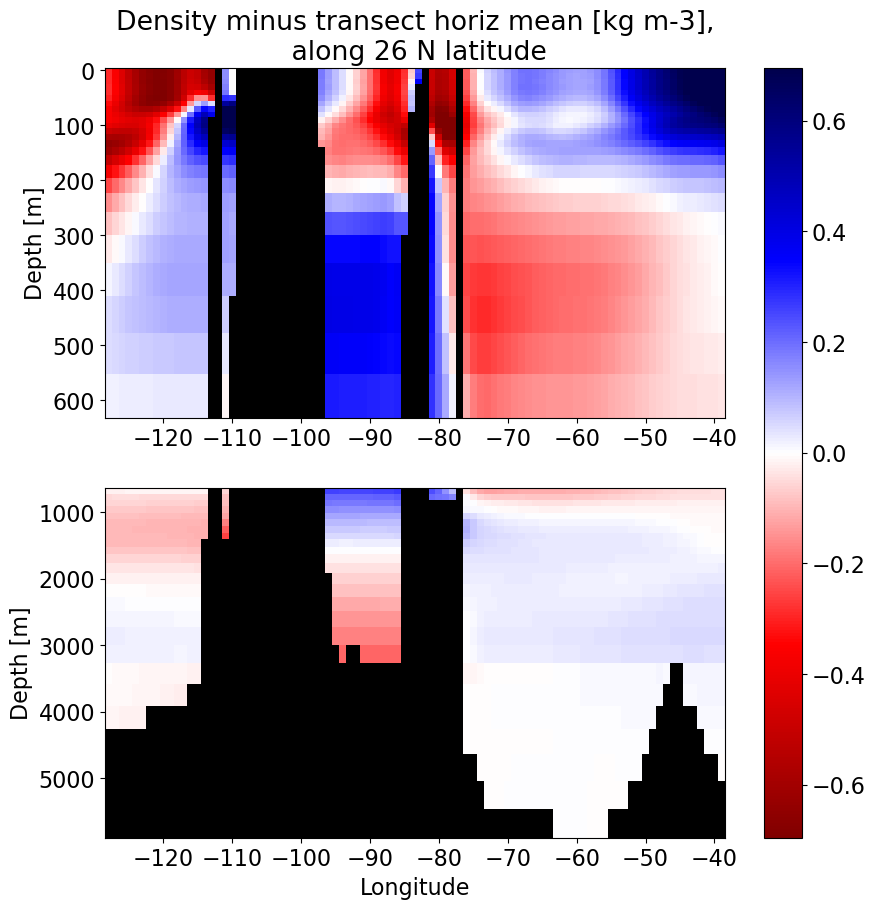

In [4]:
tile_plot = 10
i_plot = target_i
isel_dict = dict({'tile':tile_plot,'i':i_plot})
isel_dict_ig = dict({'tile':tile_plot,'i_g':i_plot})

# compute horizontal density means at each depth level
curr_mask = (~np.isnan((ds_grid.rA*dens)))
dens_mean_atdepth = ((curr_mask*ds_grid.rA*dens).isel(isel_dict).sum("j"))\
                    /((curr_mask*ds_grid.rA).isel(isel_dict).sum("j"))

# anomalies from density means at depth
dens_anom_atdepth = dens.isel(isel_dict) - dens_mean_atdepth


# function to scale colormap, coordinating among multiple plots
def cmap_zerocent_scale_multiplots(plot_objs,scale_factor):
    """
    Center colormap at zero and scale relative to existing |maximum| value across multiple plots, 
    given plot objects (as list) and scale_factor, a number of type float.
    Returns new colormap limits as new_clim.
    """
    clim_plots = np.empty((len(plot_objs),2))
    for count,curr_obj in enumerate(plot_objs):
        clim_plots[count,:] = curr_obj.get_clim()
    new_clim = (scale_factor*np.nanmax(np.abs(clim_plots)))*np.array([-1,1])
    for curr_obj in plot_objs:
        curr_obj.set_clim(new_clim)
    return new_clim


# make figure
curr_mask = land_mask.isel(isel_dict).squeeze()
fig,axs = depth_two_subplots(ds_grid.XG.isel(isel_dict_ig),-ds_grid.Zl,\
                             dens_anom_atdepth.squeeze(),\
                             k_split=25,cmap='seismic_r',mask=curr_mask)
axs[0].set_title('Density minus transect horiz mean [kg m-3],\n along 26 N latitude')
axs[1].set_xlabel('Longitude')
plot_objs = [axs[0].get_children()[0],axs[1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.8)

plt.show()

and if we instead remove the global mean at each depth level:

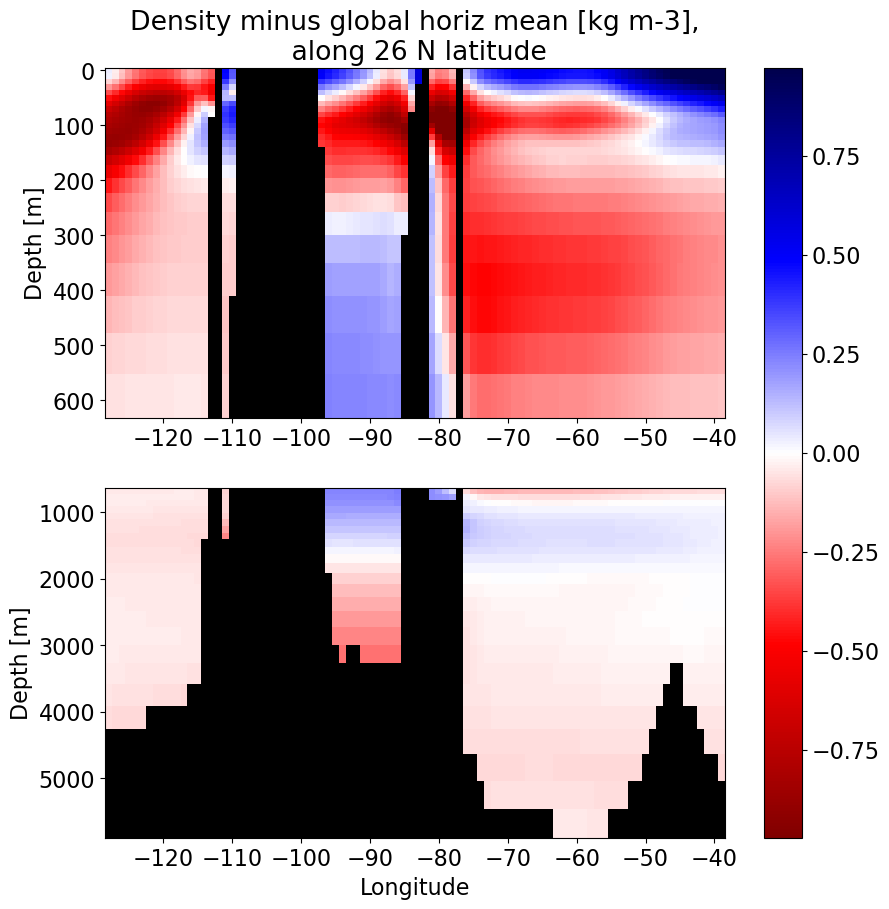

In [5]:
# compute horizontal density means at each depth level
curr_mask = (~np.isnan((ds_grid.rA*dens)))
dens_mean_atdepth = (((curr_mask*ds_grid.rA*dens).sum("tile")).sum("j")).sum("i")\
                    /((((curr_mask*ds_grid.rA).sum("tile")).sum("j")).sum("i"))

# anomalies from density means at depth
dens_anom_atdepth = dens.isel(isel_dict) - dens_mean_atdepth

# make figure
curr_mask = land_mask.isel(isel_dict).squeeze()
fig,axs = depth_two_subplots(ds_grid.XG.isel(isel_dict_ig),-ds_grid.Zl,\
                             dens_anom_atdepth.squeeze(),\
                             k_split=25,cmap='seismic_r',mask=curr_mask)
axs[0].set_title('Density minus global horiz mean [kg m-3],\n along 26 N latitude')
axs[1].set_xlabel('Longitude')
plot_objs = [axs[0].get_children()[0],axs[1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.8)

plt.show()

### Plotting along a line of latitude (multiple tiles)

All the plots above consider a transect in a single tile, but ocean basins generally span multiple tiles of the llc90 grid architecture. In the code below, we define a function that maps transects following a line of latitude, across multiple tiles if need be. Then we apply the function to plot density minus horizontal means along the Atlantic 26 N transect.

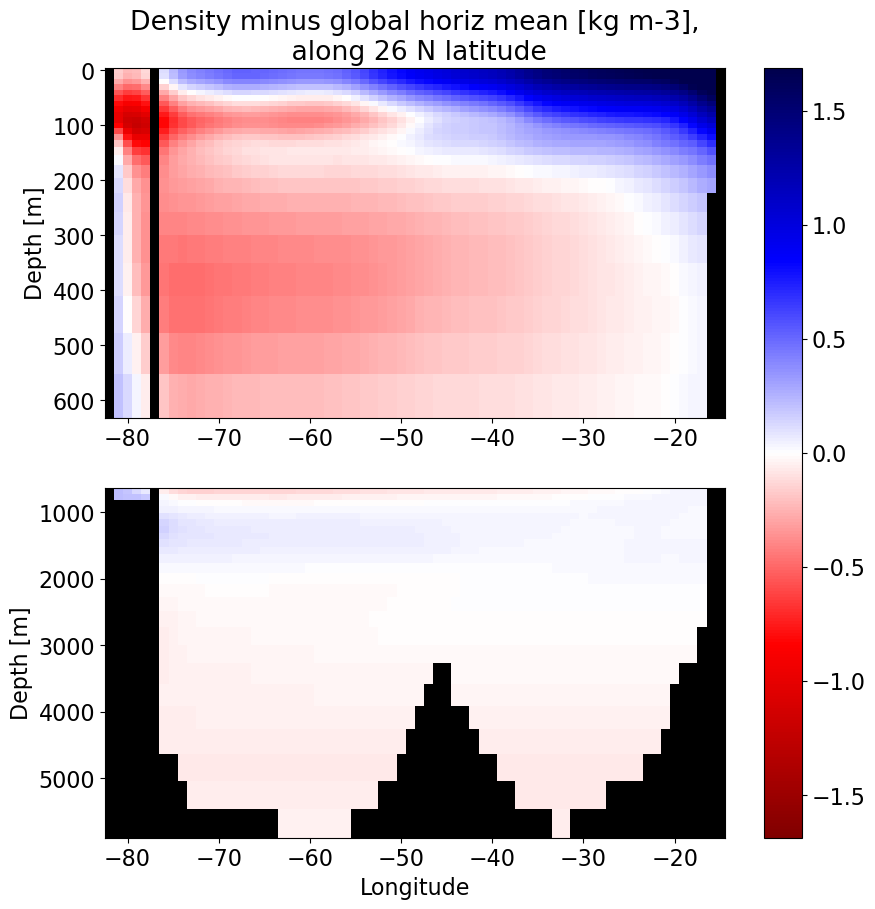

In [6]:
# define function to take modulus 360
def mod_360_range(n,low_bound):
    "Compute n mod 360; output is in the range [n,n+360)"
    out = ((n - low_bound) % 360) + low_bound
    return out

# define function to plot along line of latitude
def lon_depth_along_lat(lat_transect,lon_bnds,data):
    """
    Function takes as input parameters:
    lat_transect: line of latitude to plot along, float
    lon_bnds: 2 elements specifying western and eastern longitude bounds of transect, list or numpy array
    data: data, numpy array or xarray DataArray
    """
    
    # identify indices of grid cells along latitude transect
    mask_along_lat = np.logical_and((ds_grid.YC_bnds > lat_transect).sum("nb") > 0,\
                                    (ds_grid.YC_bnds > lat_transect).sum("nb") < 4)
    mask_in_lon_bnds = np.logical_and((mod_360_range(ds_grid.XC,lon_bnds[1]) > mod_360_range(lon_bnds[0],lon_bnds[1])),\
                                      (mod_360_range(ds_grid.XC,lon_bnds[0]) < mod_360_range(lon_bnds[1],lon_bnds[0] + 1.e-5)))
    mask_to_plot = np.logical_and(mask_along_lat,mask_in_lon_bnds)
    idx_to_plot = mask_to_plot.values.nonzero()
    XC_to_plot = np.zeros((len(idx_to_plot[0]),))
    XG_to_plot = np.zeros((len(idx_to_plot[0]),))
    # for loop through indices along transect, using zip to iterate through three spatial indices
    for count,(tile_idx,j_idx,i_idx) in enumerate(zip(idx_to_plot[0],idx_to_plot[1],idx_to_plot[2])):
        curr_XC = mod_360_range(ds_grid.XC[tile_idx,j_idx,i_idx],lon_bnds[0])
        XC_to_plot[count] = curr_XC
        XG_to_plot[count] = np.min(mod_360_range(ds_grid.XC_bnds[tile_idx,j_idx,i_idx,:],curr_XC - 180))
    # sort grid cells in order of increasing longitude
    idx_sorted = np.argsort(XC_to_plot)
    XC_to_plot = XC_to_plot[idx_sorted]
    XG_to_plot = XG_to_plot[idx_sorted]
    tile_idx_plot = idx_to_plot[0][idx_sorted]
    j_idx_plot = idx_to_plot[1][idx_sorted]
    i_idx_plot = idx_to_plot[2][idx_sorted]
    
    # construct DataArray along transect
    data_to_plot = np.empty(data.shape[:-3] + (len(idx_to_plot[0]),))
    data_to_plot.fill(np.nan)
    for count,(tile_idx,j_idx,i_idx) in enumerate(zip(tile_idx_plot,j_idx_plot,i_idx_plot)):
        if len(data.shape) == 4:
            data_to_plot[:,count] = data[:,tile_idx,j_idx,i_idx]
        elif len(data.shape) == 5:
            data_to_plot[:,:,count] = data[:,:,tile_idx,j_idx,i_idx]
    if len(data.shape) == 4:    # no time dimension
        data_xrarray = xr.DataArray(
                    data=data_to_plot.data,
                    dims=["k","lon"],
                    coords=dict(
                        Z=(["k"],ds_grid.Z.data),
                        lon=(["lon"],XC_to_plot),
                        lonW=(["lon"],XG_to_plot),
                        lat=lat_transect,
                    ),
        )
    elif len(data.shape) == 5:    # include time dimension
        data_xrarray = xr.DataArray(
                    data=data_to_plot.data,
                    dims=["time","k","lon"],
                    coords=dict(
                        time=(["time"],dens.time.data),
                        Z=(["k"],ds_grid.Z.data),
                        lon=(["lon"],XC_to_plot),
                        lonW=(["lon"],XG_to_plot),
                        lat=lat_transect,
                    ),
        )
    
    return XC_to_plot,XG_to_plot,data_xrarray

# create data array along line of latitude
lat_transect = 26.
Atl_W_bound = -82.
Atl_E_bound = -14.
lon_bnds = [Atl_W_bound,Atl_E_bound]
XC_transect,XG_transect,mask_transect = lon_depth_along_lat(lat_transect,lon_bnds,land_mask)
XC_transect,XG_transect,dens_transect = lon_depth_along_lat(lat_transect,lon_bnds,dens)

# anomalies from density means at depth
dens_anom_transect = dens_transect - np.expand_dims(dens_mean_atdepth,axis=-1)

# make figure
fig,axs = depth_two_subplots(XG_transect,-ds_grid.Zl,\
                             dens_anom_transect.squeeze(),\
                             k_split=25,cmap='seismic_r',mask=mask_transect)
axs[0].set_title('Density minus global horiz mean [kg m-3],\n along 26 N latitude')
axs[1].set_xlabel('Longitude')
plot_objs = [axs[0].get_children()[0],axs[1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.8)

plt.show()

### Thermal wind balance across Atlantic (26 N)

Now let's compute horizontal density gradients (times $g/f$) and compare with vertical velocity gradients---i.e., thermal wind balance. This calculation is complicated by the fact that density, $u$ and $v$ all start out at different positions on each grid cell, and that we take differences in both horizontal and vertical directions. To enable this to be done so that both sides of the equations end up on the same points in the grid, the calculations are done in the following order:

* Density at center of grid cells (i,j,k) --horiz difference-->
    * Horizontal density gradients at edge of grid cells (i_g,j,k) or (i,j_g,k) --horiz interpolate-->
        * Interpolated horizontal density gradients (i,j,k)


* $u$,$v$ at edge of grid cells (i_g,j,k) or (i,j_g,k) --horiz interpolate-->
    * Centered $u$,$v$ (i,j,k) --vert difference-->
        * Vertical $u$,$v$ gradients (i,j,k_l) --vert interpolate-->
            * Interpolated $u$,$v$ gradients (i,j,k)

Then we rotate velocities and gradients from model axes to geographical (zonal and meridional) axes. Finally, we apply the *lon_depth_along_lat* function used above to look at the thermal wind balance across the Atlantic basin.   

In [7]:
# load face_connections dictionary 
# (make sure you have archived this, see end of geostrophic balance tutorial)
fc_filename = 'fc_llc_13tile.json'
# read in file as dictionary
import json
with open(fc_filename,"r") as fc:
    face_connections = eval(json.load(fc))

# create xgcm Grid object
grid = xgcm.Grid(ds_grid,periodic=False,face_connections=face_connections)

In [8]:
# compute derivatives of density in x and y
d_rho_dx = (grid.diff(dens,axis="X",boundary='extend'))/ds_grid.dxC
d_rho_dy = (grid.diff(dens,axis="Y",boundary='extend'))/ds_grid.dyC
# interpolate (vector) gradient values to center of grid cells
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    # use this to ignore future warnings caused by interp_2d_vector function
    rho_grads_interp = grid.interp_2d_vector({"X":d_rho_dx,"Y":d_rho_dy},boundary='extend')
d_rho_dx = rho_grads_interp['X']
d_rho_dy = rho_grads_interp['Y']
d_rho_dx.name = 'drho_dx'
d_rho_dy.name = 'drho_dy'

g = 9.81
# compute f from latitude of grid cell centers
lat = ds_grid.YC
Omega = (2*np.pi)/86164
lat_rad = (np.pi/180)*lat    # convert latitude from degrees to radians
# expand dimensions so that f broadcasts correctly across DataArrays
f = np.expand_dims(2*Omega*np.sin(lat_rad),axis=(0,1))

# rotate from model to geographical axes
CS = np.expand_dims(ds_grid.CS,axis=(0,1))
SN = np.expand_dims(ds_grid.SN,axis=(0,1))
d_rho_zonal = (CS*d_rho_dx) - (SN*d_rho_dy)
d_rho_merid = (SN*d_rho_dx) + (CS*d_rho_dy)

# right-hand side of thermal wind balance equations
therm_wind_RHS_1 = -(g/(f*dens))*d_rho_zonal
therm_wind_RHS_2 = (g/(f*dens))*d_rho_merid

In [9]:
# load velocity dataset
download_dir = join(download_root_dir,vel_monthly_shortname)
curr_vel_file = list(glob.glob(download_dir + '/*2000-01*.nc'))
ds_vel = xr.open_dataset(curr_vel_file[0])

# interpolate velocities to center of grid cells
ds_vel.UVEL.values[np.isnan(ds_vel.UVEL.values)] = 0
ds_vel.VVEL.values[np.isnan(ds_vel.VVEL.values)] = 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vel_interp = grid.interp_2d_vector({'X':ds_vel.UVEL,'Y':ds_vel.VVEL},boundary='extend')
u = vel_interp['X']
v = vel_interp['Y']

# vertical derivatives of velocity 
# (negative sign after = because z increases upward, while k indices decrease upward)
du_dz_gridedge = -(u.diff("k").values)/np.expand_dims(ds_grid.drC[1:-1].values,axis=(0,2,3,4))
dv_dz_gridedge = -(v.diff("k").values)/np.expand_dims(ds_grid.drC[1:-1].values,axis=(0,2,3,4))

# vertical interpolation of du/dz, dv/dz
du_dz = np.empty(u.shape)
du_dz.fill(np.nan)    # fill empty numpy array with NaNs
dv_dz = np.empty(v.shape)
dv_dz.fill(np.nan)
du_dz[:,1:-1,:,:,:] = du_dz_gridedge[:,1:,:,:,:] - (np.diff(du_dz_gridedge,axis=1)/2)
dv_dz[:,1:-1,:,:,:] = dv_dz_gridedge[:,1:,:,:,:] - (np.diff(dv_dz_gridedge,axis=1)/2)
# create xarray DataArrays
du_dz_array = xr.DataArray(
                data=du_dz,
                dims=["time","k","tile","j","i"],
                coords=dict(
                    time=(["time"],u.time.data),
                    Z=(["k"],u.k.data),
                    tile=(["tile"],u.tile.data),
                    j=(["j"],u.j.data),
                    i=(["i"],u.i.data),
                ),
)
dv_dz_array = xr.DataArray(
                data=dv_dz,
                dims=["time","k","tile","j","i"],
                coords=dict(
                    time=(["time"],v.time.data),
                    Z=(["k"],v.k.data),
                    tile=(["tile"],v.tile.data),
                    j=(["j"],v.j.data),
                    i=(["i"],v.i.data),
                ),
)

# rotate from model to geographical axes
du_dz_zonal = (CS*du_dz) - (SN*dv_dz)
dv_dz_merid = (SN*du_dz) + (CS*dv_dz)

# left-hand side of thermal wind balance equations
therm_wind_LHS_1 = dv_dz_merid
therm_wind_LHS_2 = du_dz_zonal

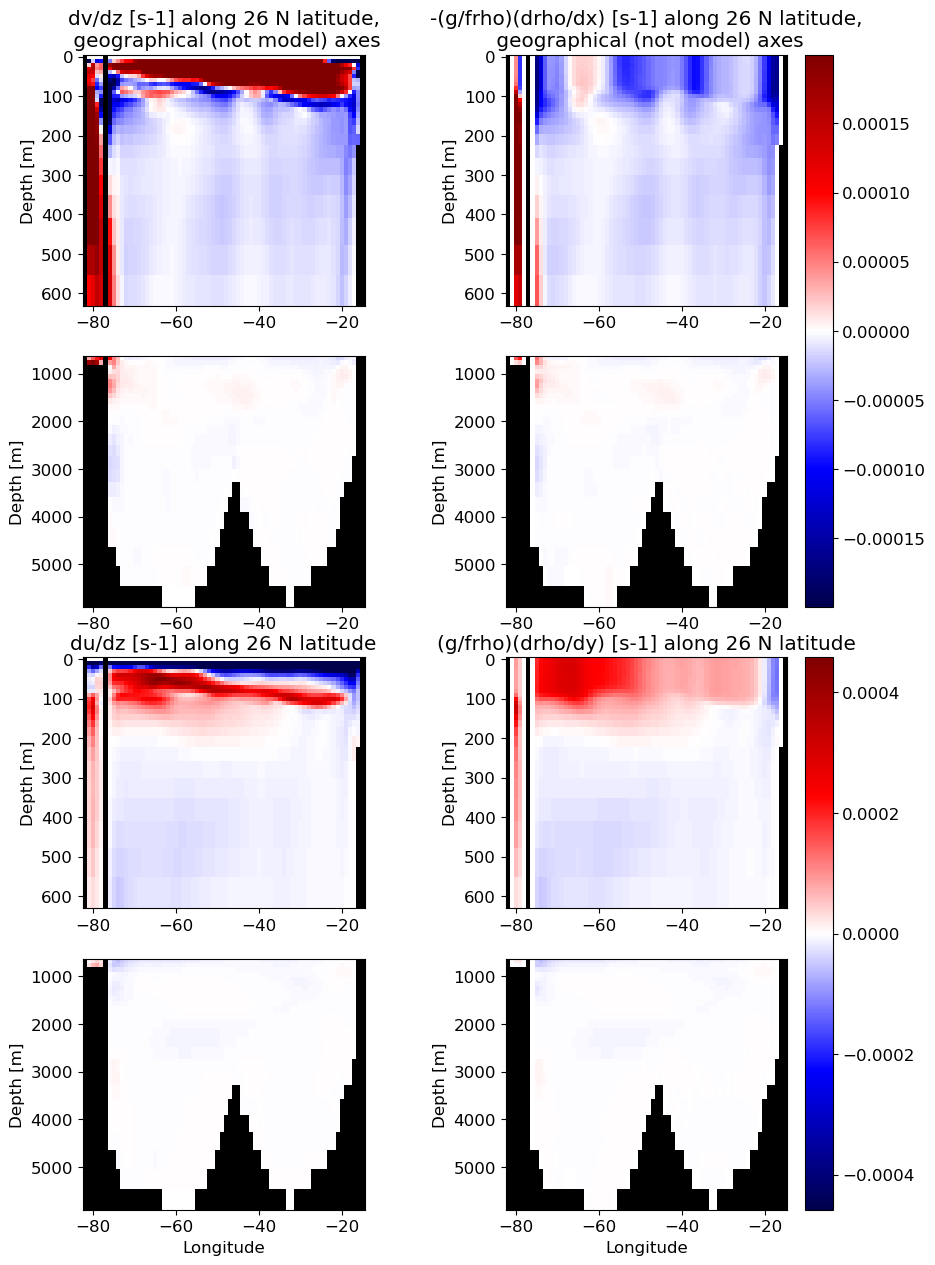

In [10]:
# generate DataArrays along line of latitude
lat_transect = 26.
Atl_W_bound = -82.
Atl_E_bound = -14.
lon_bnds = [Atl_W_bound,Atl_E_bound]
XC_transect,XG_transect,mask_transect = lon_depth_along_lat(lat_transect,lon_bnds,land_mask)
XC_transect,XG_transect,tw_LHS_1_transect = lon_depth_along_lat(lat_transect,lon_bnds,therm_wind_LHS_1)
XC_transect,XG_transect,tw_LHS_2_transect = lon_depth_along_lat(lat_transect,lon_bnds,therm_wind_LHS_2)
XC_transect,XG_transect,tw_RHS_1_transect = lon_depth_along_lat(lat_transect,lon_bnds,therm_wind_RHS_1)
XC_transect,XG_transect,tw_RHS_2_transect = lon_depth_along_lat(lat_transect,lon_bnds,therm_wind_RHS_2)

# make figure
plt.rcParams["font.size"] = 12   # change font size
fig,axs = plt.subplots(4,2,figsize=(10,15))
depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_LHS_1_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[:2,0])
axs[0,0].set_title('dv/dz [s-1] along 26 N latitude,\n geographical (not model) axes')

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_RHS_1_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[:2,1])
axs[0,1].set_title('-(g/frho)(drho/dx) [s-1] along 26 N latitude,\n geographical (not model) axes')
plot_objs = [axs[0,0].get_children()[0],axs[1,0].get_children()[0],\
             axs[0,1].get_children()[0],axs[1,1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.2)

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_LHS_2_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[2:,0])
axs[2,0].set_title('du/dz [s-1] along 26 N latitude')
axs[3,0].set_xlabel('Longitude')

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_RHS_2_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[2:,1])
axs[2,1].set_title('(g/frho)(drho/dy) [s-1] along 26 N latitude')
axs[3,1].set_xlabel('Longitude')
plot_objs = [axs[2,0].get_children()[0],axs[3,0].get_children()[0],\
             axs[2,1].get_children()[0],axs[3,1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.2)

# remove colorbars from left column plots (to declutter figure)
fig.get_children()[-4].remove()
fig.get_children()[-2].remove()

plt.show()

Note that the plots in the left and right columns are very similar at depths below ~100 meters, and very different in the top 100 meters. Why do you think this is?

## Velocity reconstruction using thermal wind

In early studies of the atmosphere and ocean, measuring in-situ velocities accurately was nearly impossible, but properties such as temperature, humidity, and salinity (that are closely related to density) could be more readily observed. Even in present-day observing systems such as atmospheric radiosondes and oceanic Argo floats, observing the density structure can tell us a lot about the movement of the fluid, because of the application of thermal wind balance.

Given the thermal wind balance equations introduced earlier, integrating vertically between two depth levels $z = z_0$ and $z = z_1$ gives us

$$
v_g(z_1) - v_g(z_0) = -\frac{g}{f}\int_{z_0}^{z_1} \frac{1}{\rho}\frac{\partial{\rho}}{\partial{x}}\, dz
$$

$$
u_g(z_1) - u_g(z_0) = \frac{g}{f}\int_{z_0}^{z_1} \frac{1}{\rho}\frac{\partial{\rho}}{\partial{y}}\, dz
$$

Since velocities in the deep ocean tend to be much smaller than those near the surface, a common technique used in oceanography has been to assume a *level of no motion*, i.e., let $u_g(z_0) = v_g(z_0) = 0$. Then upper ocean geostrophic velocities can be inferred from vertical profiles of density, spaced at regular intervals. Here we can assess the accuracy of this technique using ECCO v4r4 output.

### Along a transect

Let's integrate geostrophic velocity from a depth level where we assume the velocity is zero (even though we know from ECCO output that the velocity will not be exactly zero). In this example we'll take the level of no motion to be 3000 meters depth. Then we consider the result of this velocity reconstruction along the Atlantic 26 N transect we just considered.

In [11]:
# set level of no motion
z_0 = -3000.

# integrate (sum) RHS of thermal wind balance upward
dist_z0_upper = ds_grid.Zl - z_0
dist_z0_upper[ds_grid.Zl < z_0] = 0
delta_upper = (-dist_z0_upper.diff("k_l")).values
delta_upper = np.concatenate((delta_upper,np.array([0,])))
delta_upper = np.expand_dims(delta_upper,axis=(0,2,3,4))
v_g_reconstr_upward = (((delta_upper*therm_wind_RHS_1)\
                       .sel(k=slice(None,None,-1)))\
                        .cumsum(dim="k",skipna=True))\
                        .sel(k=slice(None,None,-1))    # slice object "flips" array along k dimension
u_g_reconstr_upward = (((delta_upper*therm_wind_RHS_2)\
                       .sel(k=slice(None,None,-1)))\
                        .cumsum(dim="k",skipna=True))\
                        .sel(k=slice(None,None,-1))    # slice object "flips" array along k dimension
v_g_reconstr_upward_interp = v_g_reconstr_upward.isel(k=np.arange(0,len(ds_grid.k) - 1))\
                            + ((v_g_reconstr_upward.diff("k").values)/2)
v_g_reconstr_upward_interp = v_g_reconstr_upward_interp.pad(k=(0,1),constant_value=0)
u_g_reconstr_upward_interp = u_g_reconstr_upward.isel(k=np.arange(0,len(ds_grid.k) - 1))\
                            + ((u_g_reconstr_upward.diff("k").values)/2)
u_g_reconstr_upward_interp = u_g_reconstr_upward_interp.pad(k=(0,1),constant_value=0)

# integrate (sum) RHS of thermal wind balance downward
dist_z0_lower = ds_grid.Zu - z_0
dist_z0_lower[ds_grid.Zu > z_0] = 0
delta_lower = (-dist_z0_lower.diff("k_u")).values
delta_lower = np.concatenate((np.array([0,]),delta_lower))
delta_lower = np.expand_dims(delta_lower,axis=(0,2,3,4))
v_g_reconstr_downward = (delta_lower*therm_wind_RHS_1)\
                       .cumsum(dim="k",skipna=True)
u_g_reconstr_downward = (delta_lower*therm_wind_RHS_2)\
                        .cumsum(dim="k",skipna=True)
v_g_reconstr_downward_interp = v_g_reconstr_downward.isel(k=np.arange(0,len(ds_grid.k) - 1))\
                                + ((v_g_reconstr_downward.diff("k").values)/2)
v_g_reconstr_downward_interp = v_g_reconstr_downward_interp.pad(k=(1,0),constant_value=0)
u_g_reconstr_downward_interp = u_g_reconstr_downward.isel(k=np.arange(0,len(ds_grid.k) - 1))\
                                + ((u_g_reconstr_downward.diff("k").values)/2)
u_g_reconstr_downward_interp = u_g_reconstr_downward_interp.pad(k=(1,0),constant_value=0)

# combine results from upward and downward integration
v_g_reconstr = v_g_reconstr_upward_interp
v_g_reconstr.values[:,v_g_reconstr.Z.values < z_0,:,:,:] = \
                                v_g_reconstr_downward_interp.values[:,v_g_reconstr.Z.values < z_0,:,:,:]
u_g_reconstr = u_g_reconstr_upward_interp
u_g_reconstr.values[:,u_g_reconstr.Z.values < z_0,:,:,:] = \
                                u_g_reconstr_downward_interp.values[:,u_g_reconstr.Z.values < z_0,:,:,:]

# rotate (actual) velocities from model to geographical axes
u_zonal = (CS*u) - (SN*v)
v_merid = (SN*u) + (CS*v)

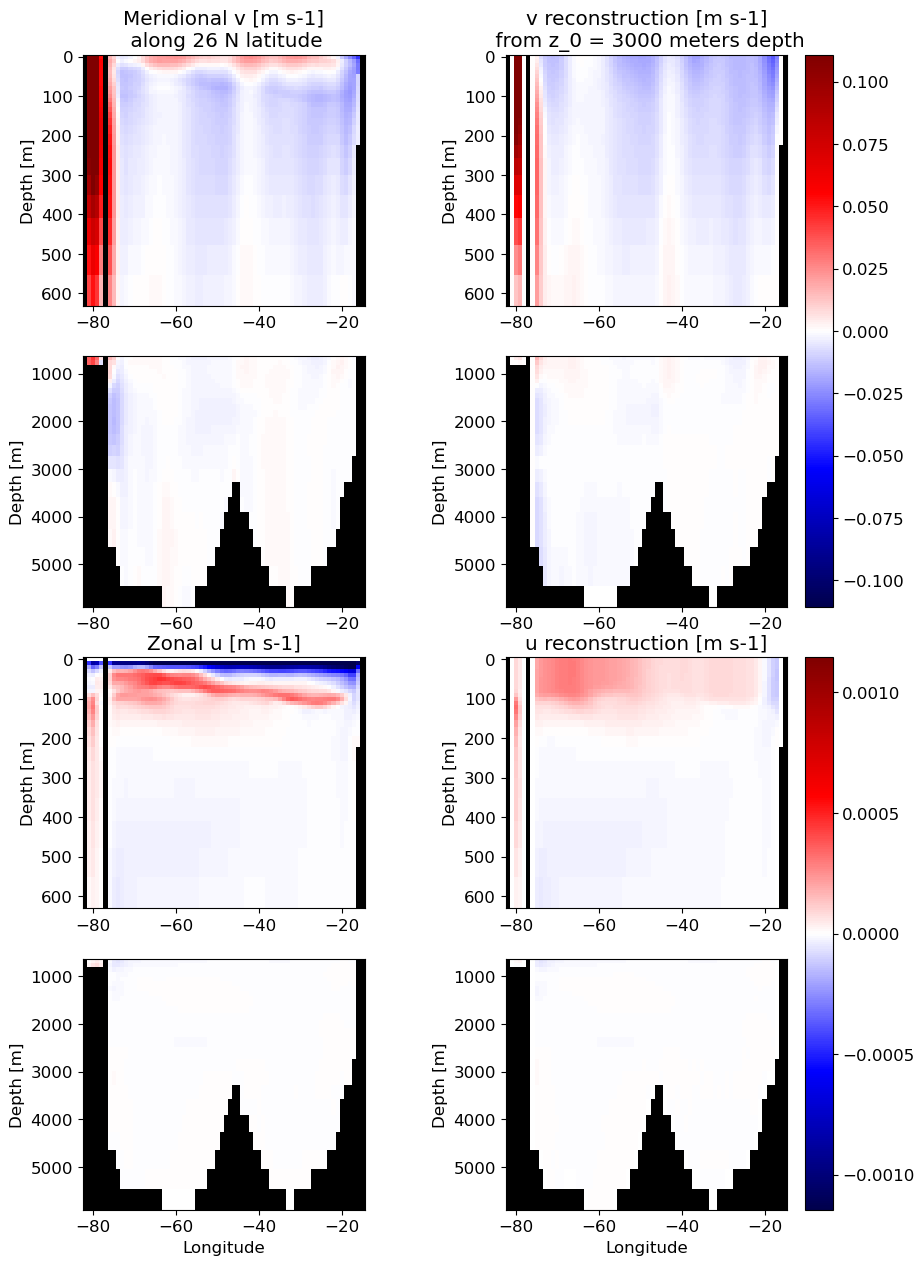

In [12]:
# generate DataArrays along line of latitude
lat_transect = 26.
Atl_W_bound = -82.
Atl_E_bound = -14.
lon_bnds = [Atl_W_bound,Atl_E_bound]
XC_transect,XG_transect,mask_transect = lon_depth_along_lat(lat_transect,lon_bnds,land_mask)
XC_transect,XG_transect,u_zonal_transect = lon_depth_along_lat(lat_transect,lon_bnds,u_zonal)
XC_transect,XG_transect,v_merid_transect = lon_depth_along_lat(lat_transect,lon_bnds,v_merid)
XC_transect,XG_transect,u_g_reconstr_transect = lon_depth_along_lat(lat_transect,lon_bnds,u_g_reconstr)
XC_transect,XG_transect,v_g_reconstr_transect = lon_depth_along_lat(lat_transect,lon_bnds,v_g_reconstr)

# make figure
plt.rcParams["font.size"] = 12   # change font size
fig,axs = plt.subplots(4,2,figsize=(10,15))
depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     v_merid_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[:2,0])
axs[0,0].set_title('Meridional v [m s-1]\n along 26 N latitude')

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     v_g_reconstr_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[:2,1])
axs[0,1].set_title('v reconstruction [m s-1]\n from z_0 = ' + str(int(-z_0)) + ' meters depth')
plot_objs = [axs[0,0].get_children()[0],axs[1,0].get_children()[0],\
             axs[0,1].get_children()[0],axs[1,1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.5)

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_LHS_2_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[2:,0])
axs[2,0].set_title('Zonal u [m s-1]')
axs[3,0].set_xlabel('Longitude')

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_RHS_2_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[2:,1])
axs[2,1].set_title('u reconstruction [m s-1]')
axs[3,1].set_xlabel('Longitude')
plot_objs = [axs[2,0].get_children()[0],axs[3,0].get_children()[0],\
             axs[2,1].get_children()[0],axs[3,1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.5)

# remove colorbars from left column plots (to declutter figure)
fig.get_children()[-4].remove()
fig.get_children()[-2].remove()

plt.show()

### Normalized RMS difference

Now as we did with geostrophic balance in the previous tutorial, we can compute the normalized RMS difference over the global domain, sorted into bins by latitude and depth. **Note: the ```RMS_diff_norm``` function may take a few minutes to run over the global domain.**

In [13]:
u_diff = u_zonal.values - u_g_reconstr
v_diff = v_merid.values - v_g_reconstr
vel_diff_complex = u_diff + (1j*v_diff)    # in Python, imaginary number i is indicated by 1j
vel_complex = u + (1j*v)

# normalize magnitude of difference vector by magnitude of actual velocity
vel_diff_abs = np.abs(vel_diff_complex)
vel_abs = np.abs(vel_complex)
vel_diff_norm = vel_diff_abs/vel_abs

# bins of latitude
lat_bin_spacing = 2
lat_bin_bounds = np.c_[-90:90:lat_bin_spacing] + np.array([[0,lat_bin_spacing]])
lat_bin_centers = np.mean(lat_bin_bounds,axis=-1)

# bins of depth
depth_bin_bounds = -ds_grid.Z_bnds.values

vel_diff_abs = np.abs(vel_diff_complex)
vel_abs = np.abs(vel_complex)

# function to loop through and compute normalized RMS difference in bins
def RMS_diff_norm(diff_abs,norm_abs,bin_field,bin_bounds,weighting):
    """
    Compute normalized RMS difference in bins, given:
    - diff_abs: absolute value (magnitude) of vector difference, e.g. u - u_g
    - norm_abs: absolute value (magnitude) of normalization vectors, e.g. u
    - bin_field: values of parameter to use in binning
    - bin_bounds: bound values of bins to use, as numpy array of size (N,2)
    - weighting: weighting of individual grid cells
    """
    RMS_diff_norm = np.empty((bin_bounds.shape[0]))
    RMS_diff_norm.fill(np.nan)
    bin_field_broadcast_flat = (np.ones(diff_abs.shape)*bin_field).flatten()
    weighting_flat = weighting.flatten()
    diff_abs_flat = diff_abs.flatten()
    norm_abs_flat = norm_abs.flatten()
    bin_idx_sorted = np.argsort(bin_field_broadcast_flat)   # flatten and sort bin field values
    sort_idx = (bin_field_broadcast_flat[bin_idx_sorted] >= bin_bounds[0,0]).nonzero()[0][0]
    curr_idx = bin_idx_sorted[sort_idx]
    curr_bin_val = bin_field_broadcast_flat[curr_idx]
    curr_bin_num = ((bin_bounds[:,0] <= curr_bin_val) & (bin_bounds[:,1] > curr_bin_val)).nonzero()[0][0]
    diff_abssq_sum = 0.
    norm_abssq_sum = 0.
    while curr_bin_val < bin_bounds[-1,1]:
        if ~np.isnan(diff_abs_flat[curr_idx]):
            diff_abssq_sum += weighting_flat[curr_idx]*(diff_abs_flat[curr_idx]**2)
            norm_abssq_sum += weighting_flat[curr_idx]*(norm_abs_flat[curr_idx]**2)
        sort_idx += 1
        if sort_idx >= len(bin_idx_sorted):
            if norm_abssq_sum > 0:
                RMS_diff_norm[curr_bin_num] = (diff_abssq_sum/norm_abssq_sum)**(1/2)
            break
        curr_idx = bin_idx_sorted[sort_idx]
        curr_bin_val = bin_field_broadcast_flat[curr_idx]
        if curr_bin_val >= bin_bounds[curr_bin_num,1]:
            if norm_abssq_sum > 0:
                RMS_diff_norm[curr_bin_num] = (diff_abssq_sum/norm_abssq_sum)**(1/2)
            curr_bin_num = ((bin_bounds[:,0] <= curr_bin_val) & (bin_bounds[:,1] > curr_bin_val)).nonzero()[0][0]
            diff_abssq_sum = 0.
            norm_abssq_sum = 0.
    return RMS_diff_norm

# compute norm RMS diff, weighting by horizontal area of grid cells
RMS_diff_norm_lat = RMS_diff_norm(vel_diff_abs.values,vel_abs.values,\
                                    ds_grid.YC.values,lat_bin_bounds,\
                                    ((ds_grid.maskC)*(ds_grid.rA)).values)
RMS_diff_norm_depth = RMS_diff_norm(vel_diff_abs.values,vel_abs.values,\
                                    np.expand_dims(-ds_grid.Z.values,axis=(-3,-2,-1)),\
                                    depth_bin_bounds,((ds_grid.maskC)*(ds_grid.rA)).values)

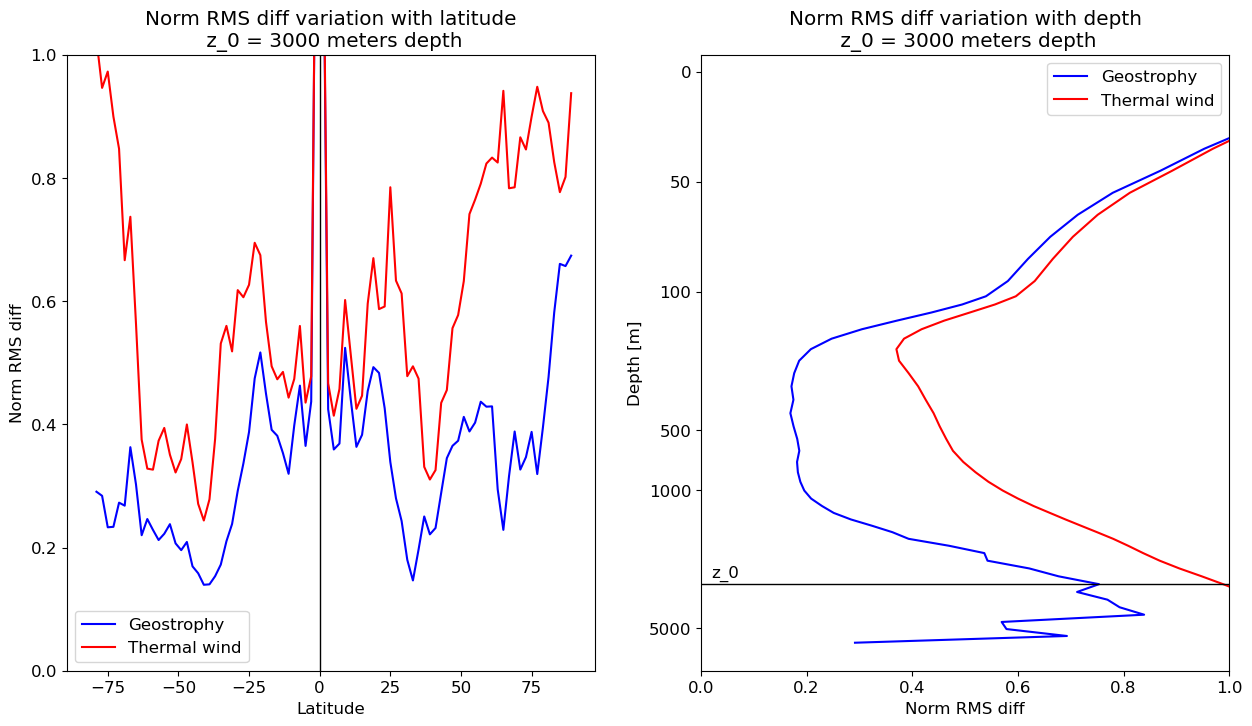

In [14]:
# load norm RMS diff from previous geostrophic balance tutorial
# (if you don't have this file run that tutorial,
# or else comment out the lines containing geostr_file below)
geostr_file = np.load('RMS_diff_norm_geostr_bal.npz')

# plot normalized RMS difference, alongside values for geostrophic balance
fig,axs = plt.subplots(1,2,figsize=(15,8))
curr_ax = axs[0]            
curr_ax.plot(lat_bin_centers,geostr_file['RMS_diff_norm_lat'],color='blue',label='Geostrophy')
curr_ax.plot(lat_bin_centers,RMS_diff_norm_lat,color='red',label='Thermal wind')
curr_ax.set_ylim(0,1)
curr_ax.axvline(x=0,color='black',lw=1)
curr_ax.set_xlabel('Latitude')
curr_ax.set_ylabel('Norm RMS diff')
curr_ax.set_title('Norm RMS diff variation with latitude\n z_0 = ' + str(int(-z_0)) + ' meters depth')
curr_ax.legend()
curr_ax = axs[1]
curr_ax.plot(geostr_file['RMS_diff_norm_depth'],-ds_grid.Z,color='blue',label='Geostrophy')
curr_ax.plot(RMS_diff_norm_depth,-ds_grid.Z,color='red',label='Thermal wind')
# Note: in older versions of Matplotlib
# may need to use linthreshy instead of linthresh
curr_ax.set_yscale('symlog',linthresh=100)
curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
curr_ax.axhline(y=-z_0,color='black',lw=1)
plt.text(0.02,-0.92*z_0,'z_0')
curr_ax.set_yticks([0,50,100,500,1000,5000])
curr_ax.set_yticklabels(['0','50','100','500','1000','5000'])
curr_ax.set_xlim(0,1)
curr_ax.set_xlabel('Norm RMS diff')
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_title('Norm RMS diff variation with depth\n z_0 = ' + str(int(-z_0)) + ' meters depth')
curr_ax.legend()

plt.show()

Comparing the geostrophy and thermal wind RMS differences provides some interesting observations. Geostrophic balance is a more accurate predictor of velocity than thermal wind, since thermal wind assumes: 
* geostrophic balance
* hydrostatic balance (not a factor here since hydrostatic balance is actually assumed in the model code itself)
* a level of no motion (a potentially more problematic assumption, especially close to $z_0$).

## Exercises

1. Try out different values of $z_0$ (i.e., level of no motion) to use in the velocity reconstructions. How does this affect the normalized RMS differences in the plots above? Which $z_0$ values permit the most accurate reconstructions (lowest RMS difference) at 100 meters depth? (For bonus points, write some code to determine the optimal $z_0$ value that minimizes normalized RMS difference at 100 m depth, rather than using trial and error.)

1. Edit the ```lon_depth_along_lat``` function above so that it plots transects following lines of longitude instead of latitude. Use this to look at the application of thermal wind to reconstruct velocities through Drake Passage (~64 deg W, 55-65 deg S).